# MBTI - 16 Personalities classifier
**Author:** Eduardo Rinaldi

**Author email:** rinaldi.1797800@studenti.uniroma1.it

**Notebook info:** Big Data Computing (`@ Sapienza University of Rome, A.Y. 2020-2021`) course project



# Introduction to the problem

## What is **MBTI**
The MBTI (Myers-Briggs Personality Type Indicator) divides everyone into **16 distinct personality** types across **4 axis**:

* Introversion (**I**) – Extroversion (**E**)
* Intuition (**N**) – Sensing (**S**)
* Thinking (**T**) – Feeling (**F**)
* Judging (**J**) – Perceiving (**P**)

This system is used in: *businesses, online, for fun, for research and lots more*.

Usually, for knowing which of the 16 personalities is closer to our one we have to answer to a questionnaire; why not automate this task?

## Learning task
Design and implement a model that given a collection of "posts" as input returns the most suited **Myers-Briggs personality type indicator (MBTI)** associated to the author.

# Setup
Before doing anything let's setup this notebook; it's designed to run on Google Colab, **BUT** setting `USING_COLAB=False` it should also run on Databricks (not full tested, so **Colab is reccomended**)

In [1]:
# Set this to False if you are on Databricks
USING_COLAB = True

Libraries used:

* **PySpark:** provides python API for Spark
* **SparkNLP:** open-source text processing library for advanced natural language processing, built on top of Spark
* **Pandas:** provides data structures and operations for manipulating numerical tables and time series
* **Matplotlib** / **Seaborn:** used for plotting
* **Tweepy:** easy-to-​use Python library for accessing Twitter API

In [ ]:
if USING_COLAB:
  !pip install colab-env
  
  # Mounting Drive
  import colab_env
  from google.colab import drive
  MOUNT_DIR = '/content/drive/'
  drive.mount(MOUNT_DIR, force_remount=True)

  # Spark and SparkNLP installation and configuration 
  !wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

  # Extra libraries installation
  !pip install pandas
  !pip install matplotlib
  !pip install git+https://github.com/tweepy/tweepy.git

  # Dataset path
  DATASETS_PATH = '/datasets/'

  # Pretrained models path
  PRETRAINED_MODELS_PATH = f'{MOUNT_DIR}MyDrive/pretrainedModels/'

  # Downloading datasets
  !wget -P $DATASETS_PATH https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/datasets/mbti_1.csv

  !wget -P $DATASETS_PATH https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/datasets/reddit_mbti.tar.gz
  !tar xvzf $DATASETS_PATH"reddit_mbti.tar.gz" -C $DATASETS_PATH
  !rm $DATASETS_PATH"reddit_mbti.tar.gz" -r

  !wget -P $DATASETS_PATH https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/datasets/mbti_and_reddit.parquet.tar.gz
  !tar xvzf $DATASETS_PATH"mbti_and_reddit.parquet.tar.gz" -C $DATASETS_PATH
  !rm $DATASETS_PATH"mbti_and_reddit.parquet.tar.gz" -r

  # Downloading pretrained models
  !wget -P $PRETRAINED_MODELS_PATH https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/pretrainedModels/pretrainedModels.tar.gz
  !tar xvzf $PRETRAINED_MODELS_PATH"pretrainedModels.tar.gz" -C $PRETRAINED_MODELS_PATH
  !rm $PRETRAINED_MODELS_PATH"pretrainedModels.tar.gz" -r

else:
  # install sparknlp and tweepy using PyPi (from databricks' UI)
  # Add com.johnsnowlabs.nlp:spark-nlp_2.12:3.1.0 to Maven

  # This procedure is very slow, set it to True only if needed
  NEED_TO_DOWNLOAD_ON_DBFS = False
  
  if NEED_TO_DOWNLOAD_ON_DBFS:
    dbutils.fs.mkdirs(DATASETS_PATH)
    dbutils.fs.mkdirs(PRETRAINED_MODELS_PATH)

    # Downloading datasets
    !wget -P /tmp https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/datasets/mbti_1.csv
    dbutils.fs.mv("file:/tmp/mbti_1.csv", DATASETS_PATH)

    !wget -P /tmp https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/datasets/reddit_mbti.tar.gz;
    !tar xvzf /tmp/reddit_mbti.tar.gz -C /tmp/
    dbutils.fs.cp("file:/tmp/reddit_mbti.parquet", DATASETS_PATH+"reddit_mbti.parquet", recurse=True)
    !rm /tmp/reddit_mbti.* -r

    !wget -P /tmp https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/datasets/mbti_and_reddit.parquet.tar.gz
    !tar xvzf /tmp/mbti_and_reddit.parquet.tar.gz -C /tmp/
    dbutils.fs.cp("file:/tmp/mbti_and_reddit.parquet", DATASETS_PATH+"mbti_and_reddit.parquet", recurse=True)
    !rm /tmp/mbti_and_reddit.* -r

    # Downloading pretrained models
    !wget -P /tmp https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/pretrainedModels/pretrainedModels.tar.gz
    !rm /tmp/tmp_pretrained -r
    !mkdir /tmp/tmp_pretrained/
    !tar xvzf /tmp/pretrainedModels.tar.gz -C /tmp/tmp_pretrained/
    dbutils.fs.cp("file:/tmp/tmp_pretrained", PRETRAINED_MODELS_PATH, recurse=True)
    !rm /tmp/tmp_pretrained -r


# Importing libraries

In [3]:
import pandas as pd
import numpy as np

# Matplotlib, plt and cm modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Seaborn for plotting
import seaborn as sns

# Pritty print
from pprint import pprint

# Twitter API
import tweepy

# for reading .env vars
import os

# PySpark
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# SparkNLP, use for text cleaning
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *              
from sparknlp.pretrained import *

spark = sparknlp.start()
spark

# MBTI Dataset
This **dataset** contains over **8600 rows of data**, and on each row contains:

* **"posts"**: last 50 things a user have posted, each entry is separated by `"|||"`
* **"type"**: MBTI type

Notice that after splitting each post we will have about **430k rows**. 

**Acknowledgements:**
This data was collected through the PersonalityCafe forum; it provides a large selection of people and their MBTI personality type.


Credits to @datasnaek, source [here](https://www.kaggle.com/datasnaek/mbti-type)

## Initial dataset analysis

Let's load the dataset into a Spark DataFrame

In [ ]:
# Path to dataset
MBTI_DATASET_PATH = f"{DATASETS_PATH}mbti_1.csv"

mbti_df = spark.read.load(MBTI_DATASET_PATH, format="csv", sep=",", inferSchema="true", header="true")
print(f"The dataset is composed by {len(mbti_df.columns)} columns and {mbti_df.count()} entries/records")
mbti_df.show()

The dataset is composed by 2 columns and 8675 entries/records
+----+--------------------+
|type|               posts|
+----+--------------------+
|INFJ|'http://www.youtu...|
|ENTP|'I'm finding the ...|
|INTP|'Good one  _____ ...|
|INTJ|'Dear INTP,   I e...|
|ENTJ|'You're fired.|||...|
|INTJ|'18/37 @.@|||Scie...|
|INFJ|'No, I can't draw...|
|INTJ|'I tend to build ...|
|INFJ|I'm not sure, tha...|
|INTP|'https://www.yout...|
|INFJ|'One time my pare...|
|ENFJ|'https://www.yout...|
|INFJ|'Joe santagato - ...|
|INTJ|'Fair enough, if ...|
|INTP|'Basically this.....|
|INTP|'Your comment scr...|
|INFJ|'some of these bo...|
|INFP|'I think we do ag...|
|INFJ|'I fully believe ...|
|INFP|'That's normal, i...|
+----+--------------------+
only showing top 20 rows



Checking empty records or null values

In [ ]:
mbti_df.where((col('posts').isNull()) | (col('type').isNull()) | (col('posts') == '') | (col('type') == '')).show()

+----+-----+
|type|posts|
+----+-----+
+----+-----+



### Column "normalization"
**Spoiler:** due to some problems, that will be discussed later, we will use **also** another dataset, so we should:

1.   Rename 'posts' column to 'post'
2.   Lowering 'type' values



In [ ]:
mbti_renamed_df = mbti_df.withColumnRenamed('posts', 'post').withColumn('type', lower("type"))
mbti_renamed_df.show()

+----+--------------------+
|type|                post|
+----+--------------------+
|infj|'http://www.youtu...|
|entp|'I'm finding the ...|
|intp|'Good one  _____ ...|
|intj|'Dear INTP,   I e...|
|entj|'You're fired.|||...|
|intj|'18/37 @.@|||Scie...|
|infj|'No, I can't draw...|
|intj|'I tend to build ...|
|infj|I'm not sure, tha...|
|intp|'https://www.yout...|
|infj|'One time my pare...|
|enfj|'https://www.yout...|
|infj|'Joe santagato - ...|
|intj|'Fair enough, if ...|
|intp|'Basically this.....|
|intp|'Your comment scr...|
|infj|'some of these bo...|
|infp|'I think we do ag...|
|infj|'I fully believe ...|
|infp|'That's normal, i...|
+----+--------------------+
only showing top 20 rows



## Are we dealing with a (Un)balanced Dataset ? 
One of the first things to check is the "frequency" of each class. 
A balanced dataset makes things easier..

### Type distribution
Let's check how MBTI types are distributed over dataset examples.

In [ ]:
def count_class_instances(df, labelCol, toPandas=True):
  """
  Given a dataframe and the column containing class labels, for each class it counts
  how many example are labeled with that class.

  It returns a new DataFrame with two columns:
    1. labelCol
    2. count: num. of examples with that label
  
  Returned DataFrame is either:
    - Spark DataFrame (if !toPandas)
    - Pandas DataFrame (if toPandas)

  Parameters
  ----------
  df : pyspark.sql.DataFrame
      Input DataFrame 
  labelCol : str
      Column where are listed class labels
  toPandas : bool, optional
      If True, function will return a Pandas DataFrame, otherwise Spark DF. (Default value is True)
  """
  counted_df = df.select(labelCol).groupBy(labelCol).count().sort(labelCol)
  return counted_df.toPandas() if toPandas else counted_df

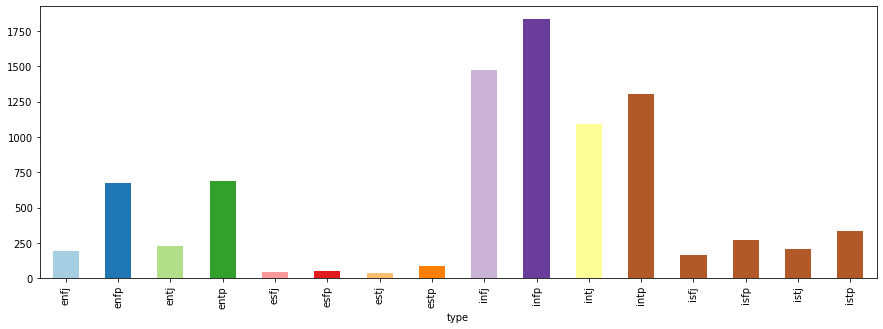

In [ ]:
# Count ""frequency"" of each class
counted_mbti_types_pdf = count_class_instances(mbti_renamed_df, 'type')
# Plot their distribution
counted_mbti_types_pdf.plot.bar(x='type', y='count', figsize=(15,5), legend=False, color=plt.cm.Paired(np.arange(16)))

The first thing that *unfortunately* we can notice is that the dataset is very **unbalanced**.

* The most predominant types are **INxx**, which correspond to introvert personalities; this could mean that on internet (especially on forums and/or social networks) the most predominant personalities are the introvert ones, so in real world application the model could deal more frequently with **INxx** types posts.

* Another thing to notice is that **Sensing** (**xSxx**) personalities are the less frequents, and that probably is due to the fact that *Sensors* prefer learning information that they can tangibly apply to their lives (**briefly:** they don't like and trust too much internet).

* Last thing to notice is that there are several classes with too few examples for applying some kind of training on them. Let's take for example "esfj" class which has **less than 250 examples**. 

### Comparing dataset distribution
Assuming that dataset distribution kinda reflect "on internet distribution", it's also useful to compare it with real world one (out of the internet); that because it provides informations about final application users.


Real world distribution provided from [here](https://personalitymax.com/personality-types/population-gender/)

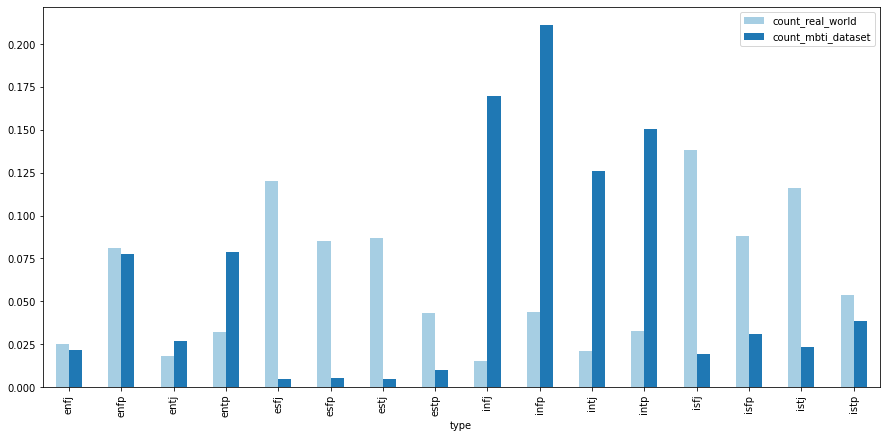

In [ ]:
# normalize count in a range [0, 1]
counted_mbti_types_pdf['count_normalized'] = counted_mbti_types_pdf['count']/counted_mbti_types_pdf['count'].sum()

# Real world distribution according to https://personalitymax.com/personality-types/population-gender/
real_world_pdf = pd.DataFrame({
    'type' : ['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp', 'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
    'count': [0.025, 0.081, 0.018, 0.032, 0.12, 0.085, 0.087, 0.043, 0.015, 0.044, 0.021, 0.033, 0.138, 0.088, 0.116, 0.054]
})
real_world_pdf.head()

# temp. DF used for plotting
pd.DataFrame({
    'type': real_world_pdf['type'],
    'count_real_world': real_world_pdf['count'],
    'count_mbti_dataset': counted_mbti_types_pdf['count_normalized']
}).plot.bar(x='type', figsize=(15, 7), color=plt.cm.Paired(np.arange(len(counted_mbti_types_pdf))))

As we can see **"real world"** and **"internet world"** distributions are **very different**. **Extroverts** are **more frequent** outside internet, same thing applies for **Sensing** personalities (**xSxx**).

## Split type in 4 indicators
Dividing type in **4 indicators** (**"I/E"**, **"N/S"**, **"T/F"**, **"P/J"**) brings us different benefits:
1. We can create 4 different models, one for each type indicator, so each model could be optimized for its own target (i.e. its own type indicator)
2. We can have 4 different datasets, each one with its own different data (or features).
3. We kinda fix "few data" problem for less frequent classes like "esfj"

So the idea is to have at the end 4 different **Binary Classifiers**, and then we can "merge" their prediction for the "final" one, but we can also do prediction on only a subset of "type indicators".

In [ ]:
def split_type(df, typeCol='type', withDrop=False):
  """
  Given a dataframe and the column containing the type of each record it splits the column 
  in 4 different columns (one for each type indicator):

    1. ie: Introversion vs Extroversion
    2. ns: Intuition vs Sensing
    3. tf: Thinking vs Feeling
    4. pj: Judging vs Perceiving
  
  It returns a pair containing:
    1. Altered dataframe
    2. Indicators columns list

  Parameters
  ----------
  df : pyspark.sql.DataFrame
      Input DataFrame which contains posts
  typeCol : str, optional
      Column where are listed post types. (Default value is 'type')
  withDrop : bool, optional
      If True drop typeCol. (Default value is False)
  """
  indicators = ['ie', 'ns', 'tf', 'pj']
  splitted_type_df = df
  # for each indicator pick the character corresponding to the current indicator and add it to a new column
  for i, ind in enumerate(indicators):
    splitted_type_df = splitted_type_df.withColumn(ind, substring(typeCol, i+1, 1))
  
  # drop typeCol column
  if withDrop:
    splitted_type_df = splitted_type_df.drop(typeCol) 
  
  return splitted_type_df, indicators

In [ ]:
# Split type in 4 indicators
mbti_type_splitted_df, indicators = split_type(mbti_renamed_df, withDrop=True)

mbti_type_splitted_df.show()

+--------------------+---+---+---+---+
|                post| ie| ns| tf| pj|
+--------------------+---+---+---+---+
|'http://www.youtu...|  i|  n|  f|  j|
|'I'm finding the ...|  e|  n|  t|  p|
|'Good one  _____ ...|  i|  n|  t|  p|
|'Dear INTP,   I e...|  i|  n|  t|  j|
|'You're fired.|||...|  e|  n|  t|  j|
|'18/37 @.@|||Scie...|  i|  n|  t|  j|
|'No, I can't draw...|  i|  n|  f|  j|
|'I tend to build ...|  i|  n|  t|  j|
|I'm not sure, tha...|  i|  n|  f|  j|
|'https://www.yout...|  i|  n|  t|  p|
|'One time my pare...|  i|  n|  f|  j|
|'https://www.yout...|  e|  n|  f|  j|
|'Joe santagato - ...|  i|  n|  f|  j|
|'Fair enough, if ...|  i|  n|  t|  j|
|'Basically this.....|  i|  n|  t|  p|
|'Your comment scr...|  i|  n|  t|  p|
|'some of these bo...|  i|  n|  f|  j|
|'I think we do ag...|  i|  n|  f|  p|
|'I fully believe ...|  i|  n|  f|  j|
|'That's normal, i...|  i|  n|  f|  p|
+--------------------+---+---+---+---+
only showing top 20 rows



### Single type indicator analysis
Let's see now for each type indicator its distribution

In [ ]:
def plot_indicators_distribution(df):
  """
  Given ad DataFrame as input, it plots each indicator distribution

  Parameters
  ----------
  df : pyspark.sql.DataFrame
      Input DataFrame
  """
  fig, ax = plt.subplots(2, 2, figsize=(10, 10))
  for ind, subplot in zip(indicators, ax.flatten()):
    sns.histplot(df.toPandas(), x=ind, ax=subplot)

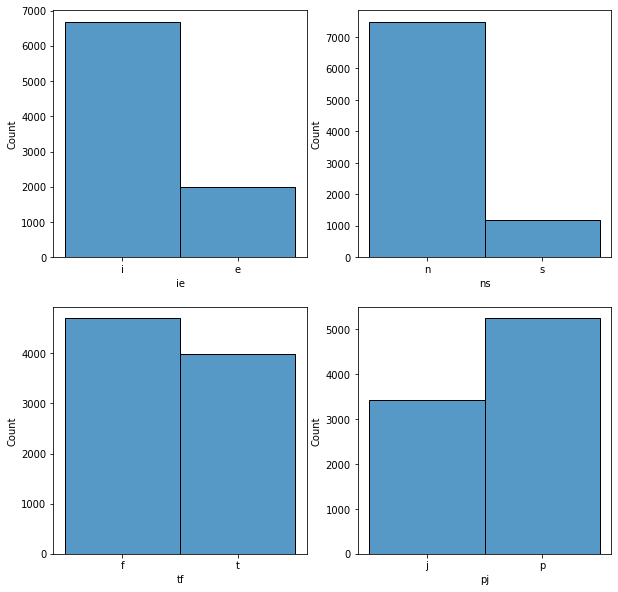

In [ ]:
plot_indicators_distribution(mbti_type_splitted_df)

As we said before the two most unbalanced type indicators are: **"I/E"** and **"N/S"**

# Reddit dataset

For obtaining a model with much more "generalization power" and for increasing the number of data to use during training phase I decided to collect new data and I came up with this new dataset.

It's a **PARQUET** dataset containing on each row:
* **redditor\_id**: posts' author id
* **post**: Last things the author posted; each entry is separated by "|||" (w.r.t. Mbti dataset, posts number on each entry ranges from 50 to 100)
* **text\_type**: identify if it's a comment, title or a post
* **type**: as the MBTI dataset
* **num\_post**: number of post in the row

This dataset contains 5754 records

## How data has been collected

Data has been collected on **Reddit** using a scraper created by me (code available [here](https://github.com/edu-rinaldi/MBTI-Predictor/tree/main/scraper)).

* First, I collected a list of users (and their personality) from 17 subreddits about MBTI ("r/mbti", "r/infp", ...); the personality information is given by a badge that is assigned to the user (**Reddit API** call it `"author_flair_text"`).

* Then, I've scraped the most recent posts of each user (max. 100 for each user) on the **ENTIRE** Reddit platform, this means that I scraped also posts not related to MBTI universe.

* At the end for each post I assigned the badge (so the personality) related to the author.

Note that : 
* "redditor_id" may appear on multiple lines as "posts", "comments", and "titles" may have been collected from the same author.
* Null values or empty values checking is not needed

## Loading dataset into a Spark DataFrame

In [ ]:
# Reddit dataset path
REDDIT_DATASET_PATH = f"{DATASETS_PATH}reddit_mbti.parquet"

reddit_df = spark.read.load(REDDIT_DATASET_PATH)
print(f"The dataset is composed by {len(reddit_df.columns)} columns and {reddit_df.count()} records")
reddit_df.show()

The dataset is composed by 5 columns and 5754 records
+-----------+----+---------+--------+--------------------+
|redditor_id|type|text_type|num_post|                post|
+-----------+----+---------+--------+--------------------+
|     101tuq|intj|  comment|     100|Arin can fred |||...|
|     114fsa|istp|  comment|     100|  ||| "Are you ki...|
|     114fsa|istp|    title|      67|Spin that wheel |...|
|     114mu2|enfp|  comment|     100|Die nerven sich m...|
|     116d0h|enfj|  comment|     100|I admire your abi...|
|   11dxh05w|infp|  comment|     100|👏 but try not to...|
|     11ghzk|isfj|  comment|     100|1: At least 4 stu...|
|     11usaf|istp|  comment|     100|She’s clearly not...|
|     11wn2y|infp|  comment|     100|Yeah, I don’t rea...|
|     12bccu|entp|    title|      50|GAME ENGINE DEVEL...|
|     12j670|entp|  comment|     100|and pink diamond ...|
|     12ryws|entp|  comment|     100|"Just a pam looki...|
|     12u7ez|esfp|  comment|     100|Not gonna lie, I ...|
|  

## Analysis
Let's compare distributions of both MBTI and Reddit datasets



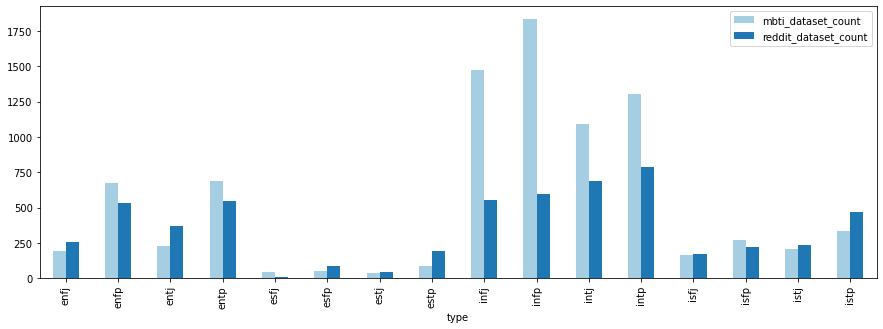

In [ ]:
counted_reddit_types_pdf = count_class_instances(reddit_df, 'type')

pd.DataFrame({
    'mbti_dataset_count': counted_mbti_types_pdf['count'],
    'reddit_dataset_count': counted_reddit_types_pdf['count'],
    'type': counted_reddit_types_pdf['type']
}).plot.bar(x='type', figsize=(15,5), color=plt.cm.Paired(np.arange(len(counted_mbti_types_pdf))))

As we can see distributions are very similar, even if reddit dataset is half smaller than "MBTI dataset". 

This can give further weight to the assumption that: internet distribution ~ MBTI and Reddit distributions

## Split type in 4 indicators
Let's split type also on this dataset

In [ ]:
reddit_splitted_df, _ = split_type(reddit_df, withDrop=True)
reddit_splitted_df.show()

+-----------+---------+--------+--------------------+---+---+---+---+
|redditor_id|text_type|num_post|                post| ie| ns| tf| pj|
+-----------+---------+--------+--------------------+---+---+---+---+
|     101tuq|  comment|     100|Arin can fred |||...|  i|  n|  t|  j|
|     114fsa|  comment|     100|  ||| "Are you ki...|  i|  s|  t|  p|
|     114fsa|    title|      67|Spin that wheel |...|  i|  s|  t|  p|
|     114mu2|  comment|     100|Die nerven sich m...|  e|  n|  f|  p|
|     116d0h|  comment|     100|I admire your abi...|  e|  n|  f|  j|
|   11dxh05w|  comment|     100|👏 but try not to...|  i|  n|  f|  p|
|     11ghzk|  comment|     100|1: At least 4 stu...|  i|  s|  f|  j|
|     11usaf|  comment|     100|She’s clearly not...|  i|  s|  t|  p|
|     11wn2y|  comment|     100|Yeah, I don’t rea...|  i|  n|  f|  p|
|     12bccu|    title|      50|GAME ENGINE DEVEL...|  e|  n|  t|  p|
|     12j670|  comment|     100|and pink diamond ...|  e|  n|  t|  p|
|     12ryws|  commen

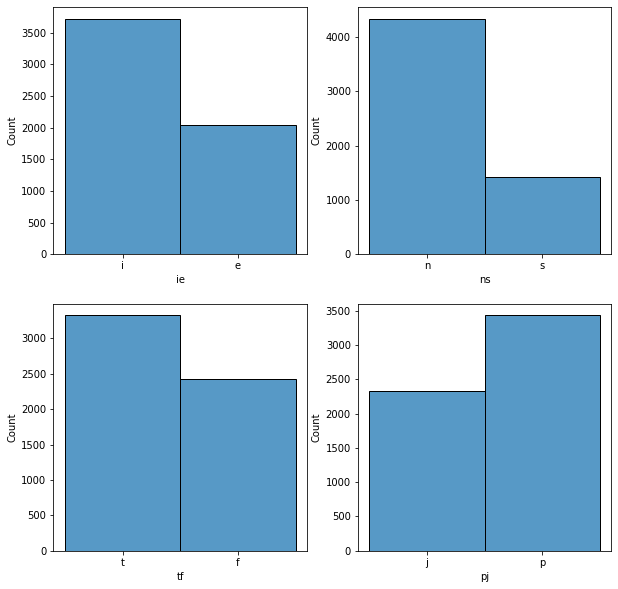

In [ ]:
plot_indicators_distribution(reddit_splitted_df)

Same unbalanced situation, just like the other dataset

# Union of MBTI dataset and Reddit dataset
Let's merge the two datasets and let's do some further analysis on them

In [ ]:
union_df = reddit_splitted_df.select('post', 'ie', 'ns', 'tf', 'pj').union(mbti_type_splitted_df)
print(f"The dataset is composed by {len(union_df.columns)} columns and {union_df.count()} records")
union_df.show()

The dataset is composed by 5 columns and 14429 records
+--------------------+---+---+---+---+
|                post| ie| ns| tf| pj|
+--------------------+---+---+---+---+
|Arin can fred |||...|  i|  n|  t|  j|
|  ||| "Are you ki...|  i|  s|  t|  p|
|Spin that wheel |...|  i|  s|  t|  p|
|Die nerven sich m...|  e|  n|  f|  p|
|I admire your abi...|  e|  n|  f|  j|
|👏 but try not to...|  i|  n|  f|  p|
|1: At least 4 stu...|  i|  s|  f|  j|
|She’s clearly not...|  i|  s|  t|  p|
|Yeah, I don’t rea...|  i|  n|  f|  p|
|GAME ENGINE DEVEL...|  e|  n|  t|  p|
|and pink diamond ...|  e|  n|  t|  p|
|"Just a pam looki...|  e|  n|  t|  p|
|Not gonna lie, I ...|  e|  s|  f|  p|
|What the fuck is ...|  e|  s|  f|  p|
|Please supply mor...|  e|  n|  t|  j|
|Why can't you guy...|  e|  n|  t|  j|
|Radio killed the ...|  e|  n|  f|  p|
|I'm actually Turb...|  i|  n|  t|  p|
|Ecuador says hack...|  i|  n|  f|  j|
|This applies to V...|  i|  n|  t|  p|
+--------------------+---+---+---+---+
only showi

Still a small dataset, but now we have almost 14.5k examples and models that we're going to train will have more generalization power because:


1.   We mixed "forum" posts with Reddit posts (different typing styles)
2.   Now "post" column contains also comments or titles (short text)
3.   Reddit dataset contains also posts not related to MBTI universe



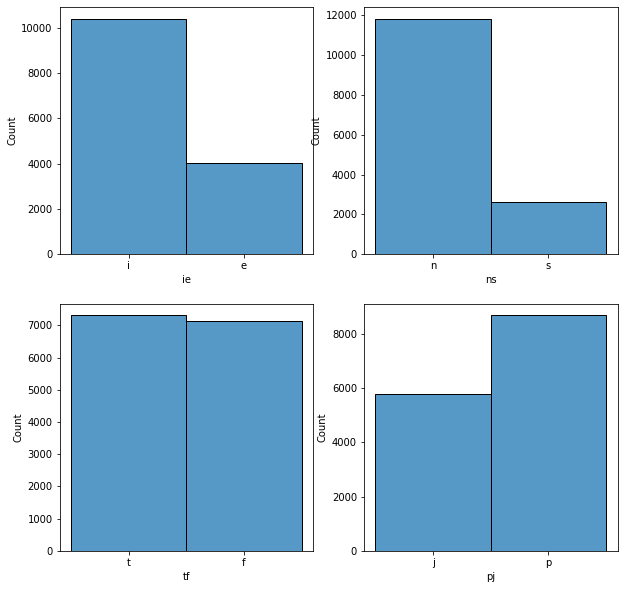

In [ ]:
plot_indicators_distribution(union_df)

# Train/Test splitting
Before doing any feature engineering let's split the dataset in to:


*   **Train set**: will be used for training (*~70%*)
*   **Test set**: will be used for testing models (*~30%*)



In [ ]:
# train/test splitting
train_df, test_df = union_df.randomSplit([0.7, 0.3])
train_df = train_df.cache()
test_df = test_df.cache()

# Feature engineering

In this section we will:

1.   **Clean** and **normalize** text (i.e.: remove link, emojis, emoticons, non alphanumeric characters and then split text in terms)
2.   Extract features

For this **two** operations we will create two different **pipelines** using `pyspark.ml.Pipeline`. 

Fitted pipelines (more in general Models) can be saved/loaded on/from disk, so let's create a function for saving models.


In [ ]:
def save_model(model, name):
  """
  Given a model, it saves it in PRETRAINED_MODELS_PATH folder, with name: name_datetime

  Parameters
  ----------
  model : pyspark.ml.base.Model
      Model to save
  name : str
      Model name
  """
  import datetime
  path = PRETRAINED_MODELS_PATH + name + f'_{datetime.datetime.now().strftime("%Y%m%d%H%M")}'
  print(f'Saving the model at this path: {path}')
  model.write().overwrite().save(path)

## Text cleaning and normalization pipeline

For creating this pipeline we will use **SparkNLP** *annotators* and *transformers*, in particular:

* `DocumentAssembler` for assembling posts as a document
* `Tokenizer` for splitting our text into words (or better "tokens")
* `Normalizer` for lowering text, removing non words (e.g. links or emojis)
* `Lemmatizer` for obtaining word's lemma, i.e. same words but in different forms will be transformed in only one word (e.g. "found" and "find" => "find")
* `StopWordsCleaner` for removing not meaningful words (e.g. "it's", "I", "and",..)
* `Finisher` for transforming pipeline output in a human readable list of terms



In [ ]:
def text_cleaning_pipeline(df, inputCol='post', outputCol='terms', saveModel=False):
  """
  Given a dataframe, an input column (inputCol) and an output column (outputCol) it
  fits a pipeline that cleans and normalizes inputCol text, and write the result on
  outputCol.
  
  It returns the fitted PipelineModel

  Parameters
  ----------
  df : pyspark.sql.DataFrame
      Input DataFrame which contains posts
  inputCol : str, optional
      Column containing text to normalize and clean. (Default value is 'post')
  outputCol : str, optional
      Column where the model will put cleaned text. (Default value is 'terms')
  saveModel : bool, optional
      If True the function will save the model. (Default value is False)
  """

  normalization_patterns = [
    '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]' + \
    '[a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', # url
    ':\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)', #emoticons
    '(\[removed\])',  # removed reddit instance
    '[^A-Za-z]',
    '([ieIE])([nsNS])([tfTF])([pjPJ])', # remove mbti words
    '([a-z])\1{2,}[\s|\w]*' # remove consecutive single chars
  ]
  
  documentAssembler = DocumentAssembler()\
    .setInputCol(inputCol)\
    .setOutputCol('document')
  
  tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')
  
  normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized')\
    .setLowercase(True)\
    .setCleanupPatterns(normalization_patterns)
  
  lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma')
  
  stopwords_cleaner = StopWordsCleaner().pretrained('stopwords_en', 'en')\
      .setInputCols('lemma')\
      .setOutputCol('cleanLemma_1')\
      .setCaseSensitive(False)

  second_stopwords_cleaner = StopWordsCleaner()\
      .setInputCols('cleanLemma_1')\
      .setOutputCol('cleanLemma_2')\
      .setCaseSensitive(False)\
      .setStopWords(['isnt', 'dont', 'ive', 'im', 'arent', 'doesnt', 'havent', 'youre'])
  
  finisher = Finisher() \
    .setInputCols(['cleanLemma_2']) \
    .setOutputCols([outputCol]) \
    .setIncludeMetadata(False)
  
  pipeline_stages = [
    documentAssembler,
    tokenizer,
    normalizer,
    lemmatizer,
    stopwords_cleaner,
    second_stopwords_cleaner,
    finisher
  ]

  # fit pipeline
  tc_pipeline_model = Pipeline(stages=pipeline_stages).fit(df)

  # save model
  if saveModel:
    save_model(tc_pipeline_model, 'tc_pipeline')

  return tc_pipeline_model

### Creating/Loading and applying the pipeline transfomations to train and test sets

In [ ]:
# Set this to False for training a new Text Cleaning Pipeline
USE_PRETRAINED_TC_PIPELINE = True
PRETRAINED_TC_PIPELINE_NAME = 'tc_pipeline_202107041409'

if USE_PRETRAINED_TC_PIPELINE:
  print(f'Using pretrained text cleaning pipeline model: {PRETRAINED_TC_PIPELINE_NAME}')
  tc_pipeline = PipelineModel.load(PRETRAINED_MODELS_PATH+PRETRAINED_TC_PIPELINE_NAME)
else:
  print('Fitting new text cleaning pipeline')
  tc_pipeline = text_cleaning_pipeline(train_df, saveModel=True)

# transforming both train and test
clean_train_df = tc_pipeline.transform(train_df)
clean_test_df = tc_pipeline.transform(test_df)

Using pretrained text cleaning pipeline model: tc_pipeline_202107041409


## Feature extraction pipeline
In this phase we're going to build a new pipeline that will extract features from text using:

1. `CountVectorizer` for obtaining terms frequency
2. `IDF` for "weighting" terms frequency
3. `PCA` for reducing dimensionality

Problems with this approach occurs when **TF-IDF** produces a very high dimensional vector (+100k): **PCA will use use all the available RAM**.

To limit this problem we have different options:

1. Use another "dimensionality reduction" strategy: the problem with this approach is that PySpark (Dataframe-based) not have any other model for doing this. MLlib implements SVD, but it's very very slow.
2. Reduce `vocabSize` in CountVectorizer increasing `minDF`: the "problem" with this approach is that PCA will have less features to analyze.
3. Use a model which is not affected by curse of dimensionality (i.e. Naive Bayes)

For this project I decided to apply (2) and (3).

In [ ]:
def feature_extraction_pipeline(df,
                                termsCol='terms',
                                outputCVFeaturesCol='cv_features',
                                cvVocabSize=262144,
                                outputIdfFeaturesCol='idf_features',
                                outputPCAFeaturesCol='pca_features',
                                pcaK=100,
                                cvMinDF=0.01,
                                indicatorsCols=['ie','ns','tf','pj'],
                                pretrainedName='',
                                saveModel=False):
  """
  Given a dataframe, an input column (termsCol) and multiple output columns 
  (outputCVFeaturesCol, outputIdfFeaturesCol, outputPCAFeaturesCol) it fits a 
  pipeline that extract features from termsCol using TF-IDF and PCA
  
  It returns the fitted PipelineModel

  Parameters
  ----------
  df : pyspark.sql.DataFrame
      Input DataFrame
  termsCol : str, optional
      Column containing terms from which to extract features. (Default value is 'terms')
  outputCVFeaturesCol : str, optional
      Column where the model will put CountVectorizer features. (Default value is 'cv_features')
  cvVocabSize : int, optional
      CountVectorizer vocabulary size. (Default value is 262144)
  outputIdfFeaturesCol : str, optional
      Column where the model will put IDF features. (Default value is 'idf_features')
  outputPCAFeaturesCol : str, optional
      Column where the model will put PCA features. (Default value is 'pca_features')
  pcaK : int, optional
      Number of PC to use. (Default value is '100')
  cvMinDF : float, optional
      Minimum frequency of a term to be included. Range [0, 1] (Default value is '0.01')
  indicatorsCols : List[int], optional
      List of indicators. (Default value is ['ie','ns','tf','pj'])
  pretrainedName : str, optional
      name of the pretrained model to load. If empty not pretrained model will be loaded (Default value is '')
  saveModel : bool, optional
      If True the function will save the model. (Default value is False)
  """

  from pyspark.ml.feature import CountVectorizer, IDF, PCA, StringIndexer
  from pyspark.ml import Pipeline, PipelineModel
  
  # if pretrainedName is not empty ==> load pretrained pipeline
  if pretrainedName != '':
    pipeline_model = PipelineModel.load(PRETRAINED_MODELS_PATH+pretrainedName)
    print(f'Using a pretrained pipeline model saved at this path: {pretrainedName}')
  else:
    print('Creating a new pipeline model')
    # CountVectorizer
    cv = CountVectorizer(inputCol=termsCol, outputCol=outputCVFeaturesCol, minDF=cvMinDF, vocabSize=cvVocabSize)
    # IDF
    idf = IDF(inputCol=outputCVFeaturesCol, outputCol=outputIdfFeaturesCol)
    # PCA
    pca = PCA(k=100, inputCol=outputIdfFeaturesCol, outputCol=outputPCAFeaturesCol)
    # StringIndexers
    string_indexers = [StringIndexer(inputCol=ind, outputCol=f"idx_{ind}") for ind in indicators]
    # if PCA K==0 ==> don't add it to pipeline
    stages = [cv, idf] + ([pca] if pcaK > 0 else []) + string_indexers
    print('Fitting the new pipeline model')
    pipeline_model = Pipeline(stages=stages).fit(df)
  
  # save pipeline
  if saveModel:
    tmp_pca_str = f'pca{pcaK}_' if pcaK > 0 else ''
    save_path = f'cv{cvMinDF}_idf_{tmp_pca_str}'
    save_model(pipeline_model, save_path)
  
  return pipeline_model

## Creating/Loading feature extraction pipeline

In [ ]:
# Set this to False for training a new Feature Extraction pipeline
USE_PRETRAINED_FE_PIPELINE = True
PRETRAINED_FE_PIPELINE_NAME = 'cv0.01_idf_pca100_202106291739'

fe_pipeline = feature_extraction_pipeline(clean_train_df, pretrainedName=PRETRAINED_FE_PIPELINE_NAME if USE_PRETRAINED_FE_PIPELINE else '')
# String indexer labels
labels = [fe_pipeline.stages[3+i].labels for i, ind in enumerate(indicators)]

# show some random samples
fe_pipeline.transform(clean_train_df).show()

Using a pretrained pipeline model saved at this path: cv0.01_idf_pca100_202106291739
+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
|                post| ie| ns| tf| pj|               terms|         cv_features|        idf_features|        pca_features|idx_ie|idx_ns|idx_tf|idx_pj|
+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
|

-I love it how ...|  i|  n|  t|  j|[love, officially...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0312529531246...|   0.0|   0.0|   0.0|   1.0|
|
I just moved int...|  i|  n|  t|  j|[move, apartment,...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0047364548986...|   0.0|   0.0|   0.0|   1.0|
|  ||| "Are you ki...|  i|  s|  t|  j|[kid, work, day, ...|(5305,[0,1,3,4,5,...|(5305,[0,1,3,4,5,...|[-0.0117535358123...|   0.0|   1.0|   0.0|   1.0|
|  ||| "A

Explained variance by PCA

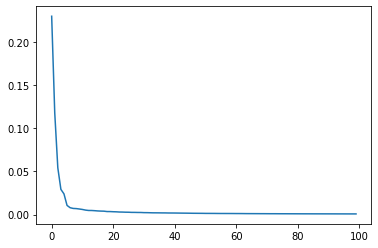

In [ ]:
# Explained Variance by PCA (from ~20 features not so much variance)
plt.plot(fe_pipeline.stages[2].explainedVariance)

### Extracting features from **train** and **test** sets

In [ ]:
final_train_df = fe_pipeline.transform(clean_train_df)
final_test_df = fe_pipeline.transform(clean_test_df)

final_train_df.show()

+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
|                post| ie| ns| tf| pj|               terms|         cv_features|        idf_features|        pca_features|idx_ie|idx_ns|idx_tf|idx_pj|
+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
|

-I love it how ...|  i|  n|  t|  j|[love, officially...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0312529531246...|   0.0|   0.0|   0.0|   1.0|
|
I just moved int...|  i|  n|  t|  j|[move, apartment,...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0047364548986...|   0.0|   0.0|   0.0|   1.0|
|  ||| "Are you ki...|  i|  s|  t|  j|[kid, work, day, ...|(5305,[0,1,3,4,5,...|(5305,[0,1,3,4,5,...|[-0.0117535358123...|   0.0|   1.0|   0.0|   1.0|
|  ||| "Are you ki...|  i|  s|  t|  p|[kid, work, day, ...|(5305,[0,1,3,4,5,...|(5305,[0,1,3,4

# Training and tuning pipelines
Now that we have extracted features from text we can give them to a training algorithm!
The goal here is to build 4 differents Binary Classifiers one for each type indicator. We'll test 4 different training algorithms:

1. Naive Bayes (**NB**)
2. Linear SVC (**SVC**)
3. Logistic Regression (**LR**)
4. Neural Network (**NN**)

NB will be the only one that will use `'idf_features'` column directly.

For each model we want to find hyperparameters that maximize some score (in this case score metric is 'f1', due to the unbalancing situation), for doing this we will use `pyspark.ml.tuning.CrossValidator`.



In [ ]:
def ml_pipeline(df,
                trainingAlgorithm,
                paramGrid,
                evaluator,
                labels,
                kFold=4,
                featuresCol='features',
                indexedTargetCol='idx_target',
                predictionCol='prediction',
                rawPredictionCol='raw_prediction',
                labeledPredictionCol='labeled_prediction', 
                metricName='f1'):
  
  """
  General function for creating a ml pipeline with hyperparameters tuning and k-fold cross validation.

  It returns a CrossValidatorModel

  Parameters
  ----------
  df : pyspark.sql.DataFrame
      Input DataFrame
  trainingAlgorithm : pyspark.ml.Predictor
      Training algorithm to use (e.g. pyspark.ml.NaiveBayes, pyspark.ml.LogisticRegression).
  paramGrid : dict
      Grid of parameters to tune (Use ParamGridBuilder for creating one)
  evaluator : pyspark.ml.evaluation.Evaluator 
      Evaluator used for evaluating trained models
  labels : List[str]
      List of target labels
  kFold : int, optional
      K parameter for K-Fold, i.e. num. of folds (Default value is '4')
  featuresCol : str, optional
      Column of features to use for training. (Default value is 'features')
  indexedTargetCol : str, optional
      Column of indexed target (Default value is 'idx_target')
  predictionCol : str, optional
      Column on which will be put prediction (Default value is 'prediction')
  rawPredictionCol : str, optional
      Column on which will be put raw prediction (Default value is 'rawPrediction')
  labeledPredictionCol : str, optional
      Column on which will be put labeled prediction (Default value is 'labeled_prediction')
  metricName : str, optional
      Metric used for choosing best model (Default value is 'f1')

  """

  from pyspark.ml.feature import IndexToString
  from pyspark.ml.tuning import CrossValidator
  from pyspark.ml import Pipeline

  # Training algorithm
  trainingAlgorithm = trainingAlgorithm.setFeaturesCol(featuresCol).setLabelCol(indexedTargetCol).setPredictionCol(predictionCol).setRawPredictionCol(rawPredictionCol)
  
  # Converts prediction to corresponding label
  idx2str = IndexToString(inputCol=predictionCol,
                          outputCol=labeledPredictionCol,
                          labels=labels)
  
  # create the pipeline
  ml_pipeline = Pipeline(stages=[trainingAlgorithm, idx2str])
  
  # create the evaluator
  evaluator = evaluator.setLabelCol(indexedTargetCol).setPredictionCol(predictionCol).setMetricName(metricName)
  
  # K-Fold cross validation for hyperparameters tuning
  return CrossValidator(estimator=ml_pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=kFold, collectSubModels=True).fit(df)

The following function will be used for calculating scores based on every metric.

In [ ]:
def evaluate_model(model, 
                   eval_df, 
                   predictionCol='prediction', 
                   labelCol='label', 
                   metrics=['accuracy', 'f1', 'precisionByLabel', 'recallByLabel', 'weightedPrecision', 'weightedRecall']):
  """
  Evaluates a given model on a certain df given as input.

  It returns a dictionary containing:
    - key <= metric name
    - value <= score achieved on that metric 

  Parameters
  ----------
  model : pyspark.ml.PredictorModel
      Model to evaluate
  eval_df : pyspark.sql.DataFrame
      DataFrame used for evaluation
  predictionCol : str, optional
      Column where predictions are listed (Default value is 'prediction')
  labelCol : str, optional
      Evaluator used for evaluating trained models (Default value is 'label')
  metric : List[str], optional
      List of metric to use for the evaluation (Default is a list of all metrics available)
  """
  
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator
  
  scores = {}
  # for each metric evaluate a score
  for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(predictionCol=predictionCol, labelCol=labelCol, metricName=metric)
    scores[metric] = evaluator.evaluate(model.transform(eval_df))
  return scores

Below cell contains all pretrained models names obtained from training

In [ ]:
# for each indicator we will have a dictionary that will contains best model for each training algorithm and its scores
best_models = {ind:{} for ind in indicators}

# ML Pipeline Models
# Set this to False if you want to train new models
USE_PRETRAINED_ML_PIPELINE = True

# Naive Bayes
PRETRAINED_NB_PIPELINE_NAMES = {
    'ie': 'nb_ie_modelTypemultinomial_202107031037',
    'ns': 'nb_ns_modelTypemultinomial_202107031037',
    'tf': 'nb_tf_modelTypemultinomial_202107031037',
    'pj': 'nb_pj_modelTypemultinomial_202107031037'
}

# Linear SVC
PRETRAINED_SVC_PIPELINE_NAMES = {
    'ie': 'svc_ie_maxIter10_regParam0.0001_202107031050',
    'ns': 'svc_ns_maxIter10_regParam0.0001_202107031102',
    'tf': 'svc_tf_maxIter10_regParam0.0001_202107031114',
    'pj': 'svc_pj_maxIter10_regParam0.0001_202107031126'
}
# Logistic Regression
PRETRAINED_LR_PIPELINE_NAMES = {
    'ie': 'lr_ie_maxIter10_regParam0.0001_elasticNetParam0.0_202107031200',
    'ns': 'lr_ns_maxIter10_regParam0.0001_elasticNetParam0.25_202107031215',
    'tf': 'lr_tf_maxIter100_regParam0.01_elasticNetParam0.0_202107031229',
    'pj': 'lr_pj_maxIter100_regParam0.0001_elasticNetParam0.0_202107031244'
}
# Neural Network
PRETRAINED_NN_PIPELINE_NAMES = {
    'ie': 'nn_ie_maxIter100_stepSize0.001_solverl-bfgs_202107040909',
    'ns': 'nn_ns_maxIter100_stepSize0.001_solverl-bfgs_202107040933',
    'tf': 'nn_tf_maxIter10_stepSize0.03_solverl-bfgs_202107040957',
    'pj': 'nn_pj_maxIter100_stepSize0.01_solverl-bfgs_202107041020'
}

## Naive Bayes Classifier
For this training algorithm we want to know only if it performs better assuming a **Multinomial** distribution or a **Gaussian**.

In [ ]:
def nb_model_tuning(df,
                    labels,
                    kFold=4,
                    allowed_indicators=['ie', 'ns', 'tf', 'pj'],
                    featuresCol='features',
                    saveModel=True):
  
  """
  Trains 4 NB classifiers (one for each indicator) using ml_pipeline

  It returns 4 best best NB classifiers found after tuning phase

  Parameters
  ----------
  df : pyspark.sql.DataFrame
      Dataframe to use for training
  labels : List[List[str]]
      List of list of target labels
  kFold : int, optional
      K parameter for K-Fold, i.e. num. of folds (Default value is '4')
  allowed_indicators : List[str], optional
      List of indicators on which we want to train a model (Default value is a list containing all 4 indicators)
  featuresCol : str, optional
      Column where features are listed (Default value is 'features')
  saveModel : bool, optional
      if True save best models found (Default value is True)
  """

  from pyspark.ml.tuning import ParamGridBuilder, CrossValidatorModel
  from pyspark.ml.classification import NaiveBayes
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  # init. an empty dictionary
  best_nb_models = dict()

  # for each indicator
  for i, ind in enumerate(allowed_indicators):
    print(f'Finding best NB model for {ind} type indicator..\n')
    nb_classifier = NaiveBayes(probabilityCol=f'{ind}_p')
    nb_param_grid = ParamGridBuilder().addGrid(nb_classifier.modelType, ['multinomial', 'gaussian']).build()
    nb_evaluator = MulticlassClassificationEvaluator()
    # Cross validation
    cv_model = ml_pipeline(df,
                           nb_classifier,
                           nb_param_grid,
                           nb_evaluator,
                           labels[i],
                           featuresCol=featuresCol,
                           indexedTargetCol=f'idx_{ind}', 
                           predictionCol=f'{ind}_pred',
                           rawPredictionCol=f'{ind}_raw_pred',
                           labeledPredictionCol=f'{ind}_labeled_pred',
                           kFold=kFold)
    # Pick best model for that indicator
    best_nb_models[ind] = cv_model.bestModel    
    # save it
    if saveModel:
      save_model(best_nb_models[ind], f'nb_{ind}_modelType{best_nb_models[ind].stages[0].getModelType()}')

    print(f'Best nb {ind} model has type {best_nb_models[ind].stages[0].getModelType()}\n')

  return best_nb_models

In [ ]:
# Pretrained NB models
if USE_PRETRAINED_ML_PIPELINE:
  print("Loading pretrained NB pipeline")
  tmp = {ind: PipelineModel.load(PRETRAINED_MODELS_PATH+name) for ind, name in PRETRAINED_NB_PIPELINE_NAMES.items()}
else:
  # Find new model
  tmp = nb_model_tuning(final_train_df, labels, featuresCol='idf_features')

for ind in indicators:
  best_models[ind]['nb'] = (tmp[ind], evaluate_model(tmp[ind], final_test_df, predictionCol=f'{ind}_pred', labelCol=f'idx_{ind}'))

pprint(best_models)

Loading pretrained NB pipeline
{'ie': {'nb': (PipelineModel_d63f43b02ed4,
               {'accuracy': 0.7374327799859715,
                'f1': 0.7414680295332422,
                'precisionByLabel': 0.8324890239783856,
                'recallByLabel': 0.7972186287192755,
                'weightedPrecision': 0.7468950656721464,
                'weightedRecall': 0.7374327799859715})},
 'ns': {'nb': (PipelineModel_ed93fdb8001d,
               {'accuracy': 0.7591769932195465,
                'f1': 0.7747686011089902,
                'precisionByLabel': 0.8929260450160772,
                'recallByLabel': 0.7993667242371906,
                'weightedPrecision': 0.8008947780129801,
                'weightedRecall': 0.7591769932195465})},
 'pj': {'nb': (PipelineModel_58af196f2fba,
               {'accuracy': 0.6679915828851999,
                'f1': 0.6623810712642277,
                'precisionByLabel': 0.7024442082890542,
                'recallByLabel': 0.7737026921576278,
               

## Linear SVC
For this training algorithm we want to find best:

* `maxIter`: max number of iterations
* `regParam`: regularization parameter for L2

In [ ]:
def svc_model_tuning(df,
                     labels,
                     kFold=4,
                     allowed_indicators=['ie', 'ns', 'tf', 'pj'],
                     featuresCol='features',
                     saveModel=True):
  
  """
  Trains 4 LinearSVC classifiers (one for each indicator) using ml_pipeline

  It returns 4 best best LinearSVC classifiers found after tuning phase

  Parameters
  ----------
  df : pyspark.sql.DataFrame
      Dataframe to use for training
  labels : List[List[str]]
      List of list of target labels
  kFold : int, optional
      K parameter for K-Fold, i.e. num. of folds (Default value is '4')
  allowed_indicators : List[str], optional
      List of indicators on which we want to train a model (Default value is a list containing all 4 indicators)
  featuresCol : str, optional
      Column where features are listed (Default value is 'features')
  saveModel : bool, optional
      if True save best models found (Default value is True)
  """

  from pyspark.ml.tuning import ParamGridBuilder, CrossValidatorModel
  from pyspark.ml.classification import LinearSVC
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  # init. empty dictionary, this will contain best model for each indicator
  best_svc_models = dict()

  # for each indicator
  for i, ind in enumerate(allowed_indicators):
    print(f'Finding best SVC model for {ind} type indicator..\n')
    svc_classifier = LinearSVC()
    svc_param_grid = ParamGridBuilder().addGrid(svc_classifier.maxIter, [10, 100]) \
    .addGrid(svc_classifier.regParam, [1, 0.5, 0.1, 0.01, 0.001, 0.0001]).build()
    
    svc_evaluator = MulticlassClassificationEvaluator()
    # Cross validation
    cv_model = ml_pipeline(df,
                           svc_classifier,
                           svc_param_grid,
                           svc_evaluator,
                           labels[i],
                           featuresCol=featuresCol,
                           indexedTargetCol=f'idx_{ind}',
                           predictionCol=f'{ind}_pred',
                           rawPredictionCol=f'{ind}_raw_pred',
                           labeledPredictionCol=f'{ind}_labeled_pred',
                           kFold=kFold)
    # Pick best model for that indicator
    best_svc_models[ind] = cv_model.bestModel
    # Save it
    if saveModel:
      save_model(best_svc_models[ind], f'svc_{ind}_maxIter{best_svc_models[ind].stages[0].getMaxIter()}_regParam{best_svc_models[ind].stages[0].getRegParam()}')
    
    print(f'Best svc {ind} model has parameters:\n\t - maxIter: {best_svc_models[ind].stages[0].getMaxIter()}\n\t - regParam: {best_svc_models[ind].stages[0].getRegParam()}\n')
  
  return best_svc_models

In [ ]:
# Pretrained SVC models
if USE_PRETRAINED_ML_PIPELINE:
  print("Loading pretrained SVC pipeline")
  tmp = {ind: PipelineModel.load(PRETRAINED_MODELS_PATH+name) for ind, name in PRETRAINED_SVC_PIPELINE_NAMES.items()}
else:
  # find new best models
  tmp = svc_model_tuning(final_train_df, labels, featuresCol='pca_features')

for ind in indicators:
  best_models[ind]['svc'] = (tmp[ind], evaluate_model(tmp[ind], final_test_df, predictionCol=f'{ind}_pred', labelCol=f'idx_{ind}'))

pprint(best_models)

Loading pretrained SVC pipeline
{'ie': {'nb': (PipelineModel_d63f43b02ed4,
               {'accuracy': 0.7374327799859715,
                'f1': 0.7414680295332422,
                'precisionByLabel': 0.8324890239783856,
                'recallByLabel': 0.7972186287192755,
                'weightedPrecision': 0.7468950656721464,
                'weightedRecall': 0.7374327799859715}),
        'svc': (PipelineModel_59bff8ef4426,
                {'accuracy': 0.7271451952303016,
                 'f1': 0.6201393170762186,
                 'precisionByLabel': 0.726951190756897,
                 'recallByLabel': 0.9970892626131953,
                 'weightedPrecision': 0.7333371713398003,
                 'weightedRecall': 0.7271451952303016})},
 'ns': {'nb': (PipelineModel_ed93fdb8001d,
               {'accuracy': 0.7591769932195465,
                'f1': 0.7747686011089902,
                'precisionByLabel': 0.8929260450160772,
                'recallByLabel': 0.7993667242371906,
         

## Logistic Regression
For this training algorithm we want to find best:

* `maxIter`: max number of iterations
* `regParam`: regularization parameter for L1 and L2
* `elasticNetParam`: value used for weighting regularization terms importance (0 use only L2, 1 use only L1)

In [ ]:
def lr_model_tuning(df,
                    labels,
                    kFold=4,
                    allowed_indicators=['ie', 'ns', 'tf', 'pj'],
                    featuresCol='features',
                    saveModel=True):
  
  """
  Trains 4 LogisticRegression classifiers (one for each indicator) using ml_pipeline

  It returns 4 best best LogisticRegression classifiers found after tuning phase

  Parameters
  ----------
  df : pyspark.sql.DataFrame
      Dataframe to use for training
  labels : List[List[str]]
      List of list of target labels
  kFold : int, optional
      K parameter for K-Fold, i.e. num. of folds (Default value is '4')
  allowed_indicators : List[str], optional
      List of indicators on which we want to train a model (Default value is a list containing all 4 indicators)
  featuresCol : str, optional
      Column where features are listed (Default value is 'features')
  saveModel : bool, optional
      if True save best models found (Default value is True)
  """

  from pyspark.ml.tuning import ParamGridBuilder, CrossValidatorModel
  from pyspark.ml.classification import LogisticRegression
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  # init. an empty dictionary, this will contain best model found for each indicator
  best_lr_models = dict()
  for i, ind in enumerate(allowed_indicators):
    print(f'Finding best LR model for {ind} type indicator..\n')
    lr_classifier = LogisticRegression(probabilityCol=f'{ind}_p')
    lr_param_grid = ParamGridBuilder().addGrid(lr_classifier.maxIter, [10, 100]) \
    .addGrid(lr_classifier.regParam, [0.05, 0.01, 0.001, 0.0005, 0.0001]) \
    .addGrid(lr_classifier.elasticNetParam, [0.0, 0.25, 0.5]).build()
    
    lr_evaluator = MulticlassClassificationEvaluator()
    # Cross validation
    cv_model = ml_pipeline(df,
                           lr_classifier,
                           lr_param_grid,
                           lr_evaluator,
                           labels[i],
                           featuresCol=featuresCol,
                           indexedTargetCol=f'idx_{ind}',
                           predictionCol=f'{ind}_pred',
                           rawPredictionCol=f'{ind}_raw_pred',
                           labeledPredictionCol=f'{ind}_labeled_pred',
                           kFold=kFold)

    # Pick best model found
    best_lr_models[ind] = cv_model.bestModel
    # Save model
    if saveModel:
      save_model(best_lr_models[ind], f'cv_lr_{ind}_maxIter{best_lr_models[ind].stages[0].getMaxIter()}_regParam{best_lr_models[ind].stages[0].getRegParam()}_elasticNetParam{best_lr_models[ind].stages[0].getElasticNetParam()}')
      
    print(f'Best LR {ind} model has parameters:\n\t - maxIter: {best_lr_models[ind].stages[0].getMaxIter()}\n\t - regParam: {best_lr_models[ind].stages[0].getRegParam()}\n\t - elasticNetParam: {best_lr_models[ind].stages[0].getElasticNetParam()}\n')
  return best_lr_models

In [ ]:
# Pretrained LogisticRegression models
if USE_PRETRAINED_ML_PIPELINE:
  print("Loading pretrained LR pipeline")
  tmp = {ind: PipelineModel.load(PRETRAINED_MODELS_PATH+name) for ind, name in PRETRAINED_LR_PIPELINE_NAMES.items()}
else:
  # Find new models
  tmp = lr_model_tuning(final_train_df, labels, featuresCol='pca_features')

for ind in indicators:
  best_models[ind]['lr'] = (tmp[ind], evaluate_model(tmp[ind], final_test_df, predictionCol=f'{ind}_pred', labelCol=f'idx_{ind}'))

pprint(best_models)

Loading pretrained LR pipeline
{'ie': {'lr': (PipelineModel_5b7ccb054f11,
               {'accuracy': 0.7299509001636661,
                'f1': 0.6545588764751447,
                'precisionByLabel': 0.7383706620723604,
                'recallByLabel': 0.9702457956015524,
                'weightedPrecision': 0.6917472141200116,
                'weightedRecall': 0.7299509001636661}),
        'nb': (PipelineModel_d63f43b02ed4,
               {'accuracy': 0.7374327799859715,
                'f1': 0.7414680295332422,
                'precisionByLabel': 0.8324890239783856,
                'recallByLabel': 0.7972186287192755,
                'weightedPrecision': 0.7468950656721464,
                'weightedRecall': 0.7374327799859715}),
        'svc': (PipelineModel_59bff8ef4426,
                {'accuracy': 0.7271451952303016,
                 'f1': 0.6201393170762186,
                 'precisionByLabel': 0.726951190756897,
                 'recallByLabel': 0.9970892626131953,
             

## Neural Network
For this training algorithm we want to find best:

* `maxIter`: max number of iterations
* `stepSize`: learning rate
* `solver`: solver algorithm for optimization
* `layers`: defines NN structure

In [ ]:
def nn_model_tuning(df,
                    labels,
                    kFold=4,
                    allowed_indicators=['ie', 'ns', 'tf', 'pj'],
                    featuresCol='features',
                    inputLayerSize=128,
                    saveModel=True):
  """
  Trains 4 Neural networks (one for each indicator) using ml_pipeline

  It returns 4 best best NN found after tuning phase

  Parameters
  ----------
  df : pyspark.sql.DataFrame
      Dataframe to use for training
  labels : List[List[str]]
      List of list of target labels
  kFold : int, optional
      K parameter for K-Fold, i.e. num. of folds (Default value is '4')
  allowed_indicators : List[str], optional
      List of indicators on which we want to train a model (Default value is a list containing all 4 indicators)
  featuresCol : str, optional
      Column where features are listed (Default value is 'features')
  inputLayerSize : int, optional
      Number of input features (Default value is '128')
  saveModel : bool, optional
      if True save best models found (Default value is True)
  """

  from pyspark.ml.tuning import ParamGridBuilder
  from pyspark.ml.classification import MultilayerPerceptronClassifier
  from pyspark.ml.tuning import CrossValidatorModel
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  # Layers to tune
  NN_LAYERS = [
               [inputLayerSize, 32, 16, 2],
               [inputLayerSize, inputLayerSize*2, inputLayerSize*2, inputLayerSize, 32, 16, 2],
               ]

  # Init. empty dictionary, this will contain best model for each indicator
  best_nn_models = dict()
  for i, ind in enumerate(allowed_indicators):
    print(f'Finding best NN model for {ind} type indicator..\n')
    nn_classifier = MultilayerPerceptronClassifier(probabilityCol=f'{ind}_p')
    nn_param_grid = ParamGridBuilder().addGrid(nn_classifier.maxIter, [10, 100]) \
    .addGrid(nn_classifier.stepSize, [0.03, 0.01, 0.001]) \
    .addGrid(nn_classifier.solver, ['gd', 'l-bfgs']) \
    .addGrid(nn_classifier.layers, NN_LAYERS).build()
    
    nn_evaluator = MulticlassClassificationEvaluator()
    # Cross validation
    cv_model = ml_pipeline(df,
                           nn_classifier,
                           nn_param_grid,
                           nn_evaluator,
                           labels[i],
                           featuresCol=featuresCol,
                           indexedTargetCol=f'idx_{ind}',
                           predictionCol=f'{ind}_pred',
                           rawPredictionCol=f'{ind}_raw_pred',
                           labeledPredictionCol=f'{ind}_labeled_pred',
                           kFold=kFold)

    # Pick best model
    best_nn_models[ind] = cv_model.bestModel
    # Save it
    if saveModel:
      save_model(best_nn_models[ind], f'nn_{ind}_maxIter{best_nn_models[ind].stages[0].getMaxIter()}_stepSize{best_nn_models[ind].stages[0].getStepSize()}_solver{best_nn_models[ind].stages[0].getSolver()}')
    
    print(f'Best NN {ind} model has parameters:\n\t'+ \
        f' - maxIter: {best_nn_models[ind].stages[0].getMaxIter()}\n\t'+ \
        f' - stepSize: {best_nn_models[ind].stages[0].getStepSize()}\n\t'+ \
        f' - solver: {best_nn_models[ind].stages[0].getSolver()}\n\t'+ \
        f' - layers: {best_nn_models[ind].stages[0].getLayers()}\n')
  return best_nn_models

In [ ]:
# Pretrained NN models
if USE_PRETRAINED_ML_PIPELINE:
  print("Loading pretrained NN pipeline")
  tmp = {ind: PipelineModel.load(PRETRAINED_MODELS_PATH+name) for ind, name in PRETRAINED_NN_PIPELINE_NAMES.items()}
else:
  # Find new models
  tmp = nn_model_tuning(final_train_df, labels, featuresCol='pca_features', inputLayerSize=100)

for ind in indicators:
  best_models[ind]['nn'] = (tmp[ind], evaluate_model(tmp[ind], final_test_df, predictionCol=f'{ind}_pred', labelCol=f'idx_{ind}'))

pprint(best_models)

Loading pretrained NN pipeline
{'ie': {'lr': (PipelineModel_5b7ccb054f11,
               {'accuracy': 0.7299509001636661,
                'f1': 0.6545588764751447,
                'precisionByLabel': 0.7383706620723604,
                'recallByLabel': 0.9702457956015524,
                'weightedPrecision': 0.6917472141200116,
                'weightedRecall': 0.7299509001636661}),
        'nb': (PipelineModel_d63f43b02ed4,
               {'accuracy': 0.7374327799859715,
                'f1': 0.7414680295332422,
                'precisionByLabel': 0.8324890239783856,
                'recallByLabel': 0.7972186287192755,
                'weightedPrecision': 0.7468950656721464,
                'weightedRecall': 0.7374327799859715}),
        'nn': (PipelineModel_a968a6bb2050,
               {'accuracy': 0.7601122281973346,
                'f1': 0.7357017944485573,
                'precisionByLabel': 0.7859911406423035,
                'recallByLabel': 0.9181759379042691,
                '

## Picking best models
Now that we trained 16 models, for each indicator we need to choose the one who performs better. Let's plot their score

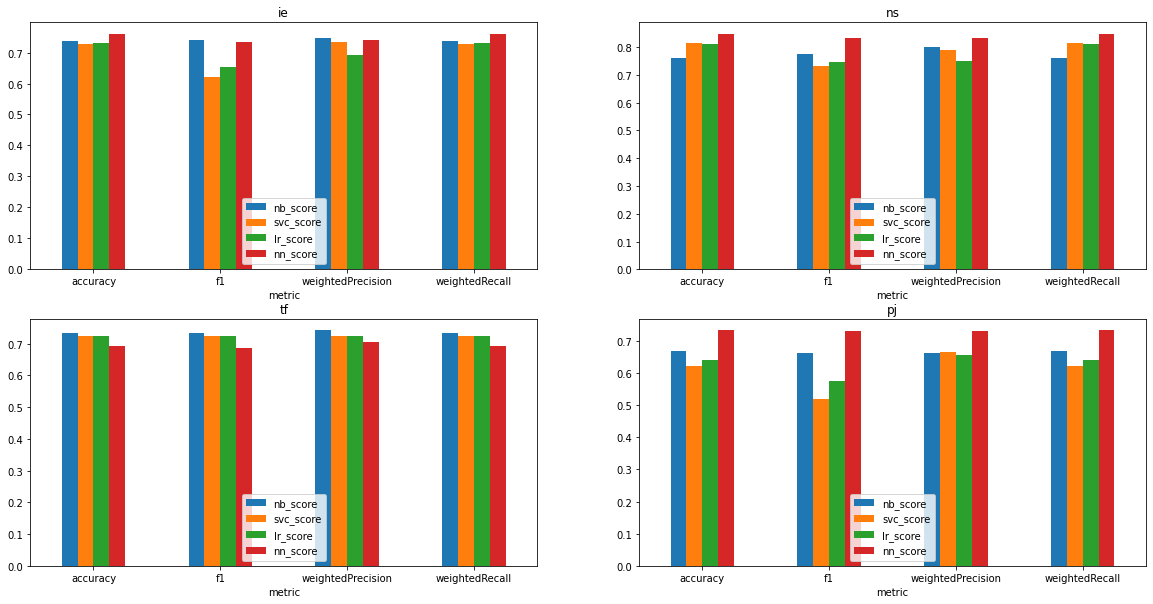

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for ind, subplot in zip(indicators, ax.flatten()):
  metrics = ['accuracy','f1', 'weightedPrecision', 'weightedRecall']
  pdf = pd.DataFrame({'metric' : metrics})

  for model_name, (model, scores) in best_models[ind].items():
    pdf[f'{model_name}_score'] = [scores[metric] for metric in metrics]
  
  pdf.plot.bar(x='metric', rot=0,title=ind, ax=subplot)


For each indicator we pick the model who performs better according to a certain metric `DISCRIMINANT_METRIC`.

Since we're dealing with an unbalanced dataset we will use `DISCRIMINANT_METRIC='f1'`

In [ ]:
# Metric used for choosing best model
DISCRIMINANT_METRIC = 'f1'

final_models = dict()
# For each indicator find the model with highest score according to DISCRIMINANT_METRIC
for ind in indicators:
  best_score = 0
  best_model_type = -1
  for model_type, (model, scores) in best_models[ind].items():
    score = scores[DISCRIMINANT_METRIC]
    if best_score < score:
      best_score = score
      best_model_type = model_type
    print(f'Model {model_type} score = {score}')
  final_models[ind] = best_models[ind][best_model_type][0]
  print(f'Best {ind} model is {best_model_type} with {DISCRIMINANT_METRIC} score = {best_score}\n')
  

pprint(final_models)

Model nb score = 0.7414680295332422
Model svc score = 0.6201393170762186
Model lr score = 0.6545588764751447
Model nn score = 0.7357017944485573
Best ie model is nb with f1 score = 0.7414680295332422

Model nb score = 0.7747686011089902
Model svc score = 0.7326276753381533
Model lr score = 0.7450046819564865
Model nn score = 0.8314306227551886
Best ns model is nn with f1 score = 0.8314306227551886

Model nb score = 0.7338614509076911
Model svc score = 0.7228785036312215
Model lr score = 0.7234572631067326
Model nn score = 0.6873932723635329
Best tf model is nb with f1 score = 0.7338614509076911

Model nb score = 0.6623810712642277
Model svc score = 0.5179402161591437
Model lr score = 0.57606844278573
Model nn score = 0.7301667584790412
Best pj model is nn with f1 score = 0.7301667584790412

{'ie': PipelineModel_d63f43b02ed4,
 'ns': PipelineModel_56434233d098,
 'pj': PipelineModel_2cb6410bbcb3,
 'tf': PipelineModel_1f0328671510}


## Merge TC - FE - ML Pipelines in one final model
Now we have everything needed for composing the final model:
1. Text cleaning pipeline
2. Feature extraction pipeline
3. IE Binary classifier
4. NS Binary classifier
5. TF Binary classifier
6. PJ Binary classifier

Let's merge all pipelines in one.

In [ ]:
def merge_models(models, saveMergedModel=False, nameMergedModel='model'):
  """
  Given a list of models as input, returns a new model composed by stages of each
  model in models.

  Parameters:
  -----------
  models : List[Model]
      List of fitted models to merge
  saveMergedModel : bool, optional
      If True save the returned model. (Default value is False)
  nameMergedModel : str, optional
      Custom name when saving model. (Default value is 'model')
  """
  stages = []
  for model in models:
    stages += model.stages
  merged_model = PipelineModel(stages=stages)
  # save merged model
  if saveMergedModel:
    save_model(merged_model, nameMergedModel)
  
  return merged_model

Two "final models" has been saved:
1. Stages: `[TC, FE, NB (for ie), NN (for ns), NB (for tf), NN (for pj)]`
2. Stages: `[TC, FE, NN (for ie), NN (for ns), SVC (for tf), NN (for pj)]`

They reach same scores

In [7]:
# Set this to False for creating a new final pipeline
USE_PRETRAINED_FINAL_PIPELINE = True

"""
2 final pipelines:
  1. [TC, FE, NB (for ie), NN (for ns), NB (for tf), NN (for pj)]
  2. [TC, FE, NN (for ie), NN (for ns), SVC (for tf), NN (for pj)]

They have pretty much same score
"""

# NB-NN-NB-NN
PRETRAINED_FINAL_PIPELINE = 'final_pipeline_202107080921'
# NN-NN-SVC-NN
#PRETRAINED_FINAL_PIPELINE = 'final_pipeline_202107050925'


if USE_PRETRAINED_FINAL_PIPELINE:
  print('Using a pretrained final model')
  final_model = PipelineModel.load(PRETRAINED_MODELS_PATH+PRETRAINED_FINAL_PIPELINE)
else:
  print('Merging tc/fe/ml pipelines')
  final_model = merge_models([tc_pipeline, fe_pipeline] + [final_models[ind] for ind in indicators], saveMergedModel=True, nameMergedModel='final_pipeline')

print('Final model stages:')
pprint(final_model.stages)

Using a pretrained final model
Final model stages:
[DocumentAssembler_b0c3a8064c23,
 REGEX_TOKENIZER_ba10aa4e8655,
 NORMALIZER_cb023efa4e30,
 LEMMATIZER_c62ad8f355f9,
 STOPWORDS_CLEANER_3e62acb2648b,
 StopWordsCleaner_0408473c60ee,
 Finisher_23a8a231812a,
 CountVectorizerModel: uid=CountVectorizer_74311f5a9216, vocabularySize=5305,
 IDFModel: uid=IDF_8542f318e886, numDocs=10097, numFeatures=5305,
 PCAModel: uid=PCA_0152f2d93653, k=100,
 StringIndexerModel: uid=StringIndexer_317a7e640ccc, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_f6c7a2bbee12, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_88a49382b8d1, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_4858f2712183, handleInvalid=error,
 NaiveBayesModel: uid=NaiveBayes_4750a1779ba5, modelType=multinomial, numClasses=2, numFeatures=5305,
 IndexToString_fa0780ad2a91,
 MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_9c5d7f70fdcd, numLayers=7, numClasses=2, numFeatures=100

# Predicting Twitter's users personalities from their posts
One of the possible application of the model just created is "*predicting Twitter's users personalities from their posts*" using **Twitter API**.

## Creating the predictor

* `MBTIPredictor`: is responsible to predict personality from a sequence of texts
* `TwitterMBTIPredictor`: is responsible to predict personality from user's posts



In [8]:
class MBTIPredictor:
  def __init__(self, model):
    """
    Parameters:
    -----------
    model : pyspark.ml.PipelineModel
        Model to use for predicting personalities
    """
    self.model = model
  
  def predict(self, *text : str):
    """
    Predict personality associated to the author of each text

    It returns a Spark DataFrame containing prediction

    Parameters:
    -----------
    text : *str
        Sequence of texts to use for prediction
    """
    text_df = spark.createDataFrame(list(text), StringType()).withColumnRenamed('value', 'post')
    return self.model.transform(text_df)
  
  def predict(self, data : dict, textCol='post'):
    """
    Predict personality associated to the author of each text.
    W.r.t. the other predict it gives the possibility to create a dataframe
    from data argument

    It returns a Spark DataFrame containing prediction

    Parameters:
    -----------
    data : dict
        Dictionary containing data from which we want to predict.
    textCol : str, optional
        Column where text to use for prediction is located (Default value is 'post')
    """
    df = spark.createDataFrame(pd.DataFrame(data)).withColumnRenamed(textCol, 'post')
    return self.model.transform(df)

class TwitterMBTIPredictor(MBTIPredictor):
  def __init__(self, model, consumer_key, consumer_secret):
    """

    Parameters:
    -----------
    model : pyspark.ml.PipelineModel
        Model to use for predicting personalities
    consumer_key : str
        Access token for twitter API
    consumer_secret : str
        Access token for twitter API
    """
    super().__init__(model)
    self.auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    self.api = tweepy.API(self.auth)

  def predict(self, users, num_of_posts=50):
    """
    Given a list of Twitter users, it predicts their personalities.

    It returns a Spark DataFrame containing prediction results

    Parameters:
    -----------
    users : List[str]
        List of twitter user (usernames)
    num_of_posts : int, optional
        Number of posts to use for prediction. (Default value is '50')
    """
    tweets = {'author': [],'post': []}
    for user in users:
      tweets['author'] += [user]
      tweets['post'] += [" ||| ".join([tweet.text for tweet in self.api.user_timeline(screen_name=user, count=num_of_posts)])]
    return super().predict(tweets)

For accessing Twitter API you'll need two values:

* `CONSUMER_KEY`
* `CONSUMER_SECRET`

This two values are personal and can be obtained by requesting access to Twitter API.

In [9]:
# Put here your CONSUMER_KEY and CONSUMER_SECRET from TwitterAPI
CONSUMER_KEY = os.getenv('CONSUMER_KEY')
CONSUMER_SECRET = os.getenv('CONSUMER_SECRET')

## Creating and testing Twitter predictor

In [10]:
twitter_predictor = TwitterMBTIPredictor(final_model, CONSUMER_KEY, CONSUMER_SECRET)

In [15]:
twitter_users = ['BarackObama', 'MichelleObama', 'BillGates', 'ConanOBrien', 'TheRock', 'morgan_freeman', 'TheElliotPage']
twitter_predictor.predict(users=twitter_users, num_of_posts=75) \
.select('author', 'post', 'terms','ie_labeled_pred', 'ns_labeled_pred', 'tf_labeled_pred', 'pj_labeled_pred') \
.show()

+--------------+--------------------+--------------------+---------------+---------------+---------------+---------------+
|        author|                post|               terms|ie_labeled_pred|ns_labeled_pred|tf_labeled_pred|pj_labeled_pred|
+--------------+--------------------+--------------------+---------------+---------------+---------------+---------------+
|   BarackObama|Michelle and I sa...|[michelle, sit, t...|              e|              n|              f|              p|
| MichelleObama|Happy Fourth of J...|[happy, fourth, j...|              e|              n|              f|              p|
|     BillGates|This expanded com...|[expand, commitme...|              e|              n|              t|              j|
|   ConanOBrien|Brenna claims to ...|[brenna, claim, f...|              e|              n|              t|              j|
|       TheRock|🚨You’re official...|[officially, noti...|              e|              n|              f|              p|
|morgan_freeman|C

We can compare these results with the one proposed [on this website](https://www.crystalknows.com/famous-people).

*   **Barack Obama:** enfj
*   **Michelle Obama:** intj
*   **Bill Gates:** intj
*   **Conan O'Brien:** entp
*   **Dwayne Johnson:** entp 
*   **Morgan Freeman:** infj
*   **Elliot Page:** intp


# **Another approach:** single post prediction
This is another approach that we could experiment and:

* It gives us more examples (each entry is a post, not a user collection of posts)
* It is more difficult: is hard to classify a post based on few words

Let's give it a try!

## Splitting posts by '|||'
We will start from `union_df` dataset (`mbti_df + reddit_df`); we can split each row in multiple rows by `"|||"` string.
For "caching" the result I created another dataset called `"mbti_and_reddit.parquet"` which has been already splitted.

In [ ]:
# Put this to False if you want to not use the cached dataset (slower)
USE_PRESPLITTED_UNION_DF = True

UNION_DATASET_PATH = f'{DATASETS_PATH}mbti_and_reddit.parquet'

# Se this to True if you want to save the dataset
SAVE_DATASET = False

if USE_PRESPLITTED_UNION_DF:
  print(f'Loading dataset at {UNION_DATASET_PATH}')
  single_post_union_df = spark.read.parquet(UNION_DATASET_PATH)
  indicators = ['ie','ns','tf','pj']
else:
  single_post_union_df = union_df.withColumn('post', explode(split("post", "\|\|\|"))).where(col('post') != '')

if SAVE_DATASET:
  print(f'Dataset save at {UNION_DATASET_PATH}')
  single_post_union_df.write.parquet(UNION_DATASET_PATH)

single_post_union_df.show()
print(f'Dataset is composed by {len(single_post_union_df.columns)} columns and {single_post_union_df.count()} records')

Loading dataset at /datasets/mbti_and_reddit.parquet
+--------------------+---+---+---+---+
|                post| ie| ns| tf| pj|
+--------------------+---+---+---+---+
|      Arin can fred |  i|  n|  t|  j|
| You know, it's f...|  i|  n|  t|  j|
| Meanwhile I'm dy...|  i|  n|  t|  j|
| Especially with ...|  i|  n|  t|  j|
| What? Is this a ...|  i|  n|  t|  j|
| Ja, og de var va...|  i|  n|  t|  j|
| Norwegian here. ...|  i|  n|  t|  j|
| I love it. Can't...|  i|  n|  t|  j|
|             Whohoo |  i|  n|  t|  j|
| ISTJ - Accountin...|  i|  n|  t|  j|
| I think ISTJ's b...|  i|  n|  t|  j|
| I think the most...|  i|  n|  t|  j|
| All talks machin...|  i|  n|  t|  j|
| Well of course D...|  i|  n|  t|  j|
| The fact that Ar...|  i|  n|  t|  j|
| Now we finally h...|  i|  n|  t|  j|
| I'm just pulling...|  i|  n|  t|  j|
| Holy fuck man, I...|  i|  n|  t|  j|
| ISTJ's normaly w...|  i|  n|  t|  j|
| I saw Edguy in s...|  i|  n|  t|  j|
+--------------------+---+---+---+---+
only showin

As we can see now we have almost 1 millions records!!

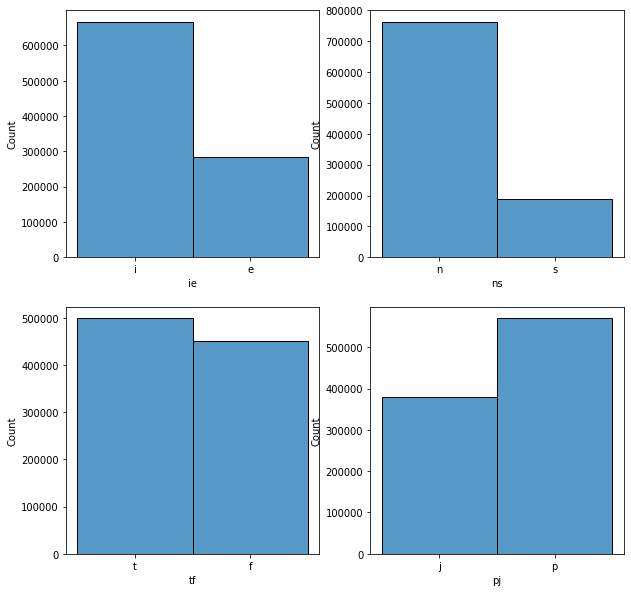

In [ ]:
plot_indicators_distribution(single_post_union_df)

Classes are still unbalanced, but now we *could* also apply "*undersampling*" because we have a lot of data to use for training. (We're not going for it)

Notice also that undersampling here can be done in a "smart" way: 
* 4 different datasets are created, one for each indicator, so for each binary classifier
* For each dataset we undersample majority class examples until we reach a balanced situation.

In our case we would have:
1. **IE dataset:** undersample majority class (i.e. "*I*") to 300k examples (600k total examples)
2. **NS dataset:** undersample majority class (i.e. "*N*") to 200k examples (400k total examples)
3. **TF dataset:** undersample majority class (i.e. "*T*") to 450k examples (900k total examples)
4. **PJ dataset:** undersample majority class (i.e. "*P*") to ~400k examples (~800k total examples)

But, as said before we're not going for this approach.


## Split into training and test set

In [ ]:
train_df, test_df = single_post_union_df.randomSplit([0.7, 0.3])

## Testing previous approach model on this dataset
Before procedeing to explore "single post" approach, it is useful to evaluate "grouped posts" final model on this dataset, for different reasons:

1. To see how it performs on short text and single posts
2. To compare it later with "single approach" models

In [ ]:
test_df.cache()
final_model_scores = {}
for ind in indicators:
  final_model_scores[ind] = evaluate_model(final_model, test_df, predictionCol=f'{ind}_pred', labelCol=f'idx_{ind}')
  print(f'{ind} => {final_model_scores[ind]}\n')

ie => {'accuracy': 0.6661745268427122, 'f1': 0.6273821156928534, 'precisionByLabel': 0.7152328040134334, 'recallByLabel': 0.8677938306135179, 'weightedPrecision': 0.6181136916550377, 'weightedRecall': 0.6661745268427122}

ns => {'accuracy': 0.8007466464186282, 'f1': 0.7173953349041853, 'precisionByLabel': 0.8037280740523359, 'recallByLabel': 0.9948749819464565, 'weightedPrecision': 0.702259851515482, 'weightedRecall': 0.8007466464186282}

tf => {'accuracy': 0.5778494895806968, 'f1': 0.5781022080138358, 'precisionByLabel': 0.6021087485706669, 'recallByLabel': 0.5752642408562946, 'weightedPrecision': 0.5789865328421927, 'weightedRecall': 0.5778494895806969}

pj => {'accuracy': 0.4028234764757164, 'f1': 0.24539311094986618, 'precisionByLabel': 0.5934885824101289, 'recallByLabel': 0.015377225304176161, 'weightedPrecision': 0.5160342234349908, 'weightedRecall': 0.40282347647571637}



It doesn't seem to perform well... except for 'ns' indicator. But now, let's continue with "single post" approach.

## Features engineering
We need to:

1. Clean and normalize text
2. Extract features

We can use same functions used for the other approach for fitting **new** text cleaning and features extraction pipelines based on this other dataset.

### Text cleaning and normalization

In [ ]:
# Set this to False for fitting a new text cleaning pipeline
USE_PRETRAINED_TC_PIPELINE = True
PRETRAINED_TC_PIPELINE_NAME = 'tc_pipeline_202107050659'

if USE_PRETRAINED_TC_PIPELINE:
  print(f'Using pretrained text cleaning pipeline, located at {PRETRAINED_MODELS_PATH+PRETRAINED_TC_PIPELINE_NAME}')
  tc_pipeline = PipelineModel.load(PRETRAINED_MODELS_PATH+PRETRAINED_TC_PIPELINE_NAME)
else:
  tc_pipeline = text_cleaning_pipeline(train_df, saveModel=True)

Using pretrained text cleaning pipeline, located at /content/drive/MyDrive/pretrainedModels/tc_pipeline_202107050659


cleaning both train and test sets

In [ ]:
# Text cleaning on both train and test sets
clean_train_df = tc_pipeline.transform(train_df)
clean_test_df = tc_pipeline.transform(test_df)

### Feature extraction pipeline

In [ ]:
# Set this to False for fitting a new feature extraction pipeline
USE_PRETRAINED_FE_PIPELINE = True
PRETRAINED_FE_PIPELINE_NAME = 'cv0.0001_idf_pca100__202107051202'

if USE_PRETRAINED_FE_PIPELINE:
  print(f'Using pretrained feature extraction pipeline, located at {PRETRAINED_MODELS_PATH+PRETRAINED_FE_PIPELINE_NAME}')
  fe_pipeline = PipelineModel.load(PRETRAINED_MODELS_PATH+PRETRAINED_FE_PIPELINE_NAME)
else: 
  fe_pipeline = feature_extraction_pipeline(clean_train_df, pcaK=100, cvMinDF=0.0001, saveModel=True)

labels = [fe_pipeline.stages[3+i].labels for i, ind in enumerate(indicators)]

Using pretrained feature extraction pipeline, located at /content/drive/MyDrive/pretrainedModels/cv0.0001_idf_pca100__202107051202


Explained variance by using 100 features

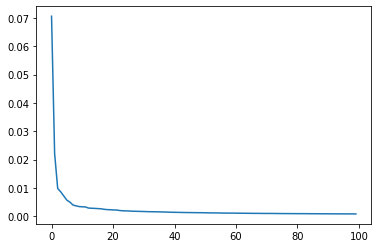

In [ ]:
plt.plot(fe_pipeline.stages[2].explainedVariance)

Variance, this time, is low also for PC1

**Extracting features from both train and test sets**

In [ ]:
# Feature extraction on train and test sets
fe_train_df = fe_pipeline.transform(clean_train_df)
fe_test_df = fe_pipeline.transform(clean_test_df)

fe_train_df.show()

+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
|                post| ie| ns| tf| pj|               terms|         cv_features|        idf_features|        pca_features|idx_ie|idx_ns|idx_tf|idx_pj|
+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
|

-I love it how ...|  i|  n|  t|  j|[love, officially...|(7441,[1,2,4,5,6,...|(7441,[1,2,4,5,6,...|[-8.1282495587694...|   0.0|   0.0|   0.0|   1.0|
|
I just moved int...|  i|  n|  t|  j|[move, apartment,...|(7441,[1,4,85,102...|(7441,[1,4,85,102...|[4.00696065288476...|   0.0|   0.0|   0.0|   1.0|
| 









I'm no...|  e|  n|  f|  p|[lot, common, med...|(7441,[11,24,26,1...|(7441,[11,24,26,1...|[5.11686459813983...|   1.0|   0.0|   1.0|   0.0|
| 



Sorry I'm la...|  e|  n|  f|  p|[late, post, year...|(7441,[2,3,6,12,1...|(7441,[2,3,6,1

Let's **cache results**

In [ ]:
# Caching results
final_train_df = fe_train_df.cache()
final_test_df = fe_test_df.cache()

final_train_df.show()

+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
|                post| ie| ns| tf| pj|               terms|         cv_features|        idf_features|        pca_features|idx_ie|idx_ns|idx_tf|idx_pj|
+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
|

-I love it how ...|  i|  n|  t|  j|[love, officially...|(7441,[1,2,4,5,6,...|(7441,[1,2,4,5,6,...|[-8.1282495587694...|   0.0|   0.0|   0.0|   1.0|
|
I just moved int...|  i|  n|  t|  j|[move, apartment,...|(7441,[1,4,85,102...|(7441,[1,4,85,102...|[4.00696065288476...|   0.0|   0.0|   0.0|   1.0|
| 









I'm no...|  e|  n|  f|  p|[lot, common, med...|(7441,[11,24,26,1...|(7441,[11,24,26,1...|[5.11686459813983...|   1.0|   0.0|   1.0|   0.0|
| 



Sorry I'm la...|  e|  n|  f|  p|[late, post, year...|(7441,[2,3,6,12,1...|(7441,[2,3,6,1

## ML Models training
For this approach we will test first **only two** train algorithms, which are the ones who performed best on the other approach:

* **Naive Bayes:** using *TF-IDF features*
* **Neural Network:** *using PCA features*

This choice is due to the fact that training 16 models (4 training algorithms * 4 indicators) using cross validation is computationally expensive.

In [ ]:
# for each indicator we will have a dictionary that will contains best model for each training algorithm and its scores
best_models = {ind:{} for ind in indicators}

# ML Pipeline Models
# Set this to False if you want to train new models
USE_PRETRAINED_ML_PIPELINE = True

# Naive Bayes
PRETRAINED_NB_PIPELINE_NAMES = {
    'ie': 'nb_ie_modelTypemultinomial_202107051347',
    'ns': 'nb_ns_modelTypemultinomial_202107051349',
    'tf': 'nb_tf_modelTypemultinomial_202107051351',
    'pj': 'nb_pj_modelTypemultinomial_202107051353'
}

# Neural Network
PRETRAINED_NN_PIPELINE_NAMES = {
    'ie': 'nn_ie_maxIter10_stepSize0.01_solverl-bfgs_202107062119',
    'ns': 'nn_ns_maxIter10_stepSize0.01_solverl-bfgs_202107070125',
    'tf': 'nn_tf_maxIter10_stepSize0.01_solverl-bfgs_202107071103',
    'pj': 'nn_pj_maxIter10_stepSize0.01_solvergd_202107071349'
}

### Naive Bayes

In [ ]:
# Pretrained NB models
if USE_PRETRAINED_ML_PIPELINE:
  print("Loading pretrained NB pipeline")
  tmp = {ind: PipelineModel.load(PRETRAINED_MODELS_PATH+name) for ind, name in PRETRAINED_NB_PIPELINE_NAMES.items()}
else:
  tmp = nb_model_tuning(final_train_df, labels, featuresCol='idf_features')

for ind in indicators:
  best_models[ind]['nb'] = (tmp[ind], evaluate_model(tmp[ind], final_test_df, predictionCol=f'{ind}_pred', labelCol=f'idx_{ind}'))
  
pprint(best_models)

Loading pretrained NB pipeline
{'ie': {'nb': (PipelineModel_66a823fe4045,
               {'accuracy': 0.6194051249055865,
                'f1': 0.6200906814002721,
                'precisionByLabel': 0.7291658287415035,
                'recallByLabel': 0.7251518712032199,
                'weightedPrecision': 0.6207930169365878,
                'weightedRecall': 0.6194051249055864})},
 'ns': {'nb': (PipelineModel_ba283dfc6022,
               {'accuracy': 0.6867884018239293,
                'f1': 0.6989349792617146,
                'precisionByLabel': 0.8242853967136585,
                'recallByLabel': 0.7751433934489772,
                'weightedPrecision': 0.7136569617943156,
                'weightedRecall': 0.6867884018239293})},
 'pj': {'nb': (PipelineModel_8a8a63945d9b,
               {'accuracy': 0.5802479928385599,
                'f1': 0.572796428811591,
                'precisionByLabel': 0.6359372856856477,
                'recallByLabel': 0.7025907037738598,
                

### Neural Network

In [ ]:
# Pretrained NN models
if USE_PRETRAINED_ML_PIPELINE:
  print("Loading pretrained NN pipeline")
  tmp = {ind: PipelineModel.load(PRETRAINED_MODELS_PATH+name) for ind, name in PRETRAINED_NN_PIPELINE_NAMES.items()}
else:
  tmp = nn_model_tuning(final_train_df, labels, featuresCol='pca_features', inputLayerSize=100)

for ind in indicators:
  best_models[ind]['nn'] = (tmp[ind], evaluate_model(tmp[ind], final_test_df, predictionCol=f'{ind}_pred', labelCol=f'idx_{ind}'))

pprint(best_models)

Loading pretrained NN pipeline
{'ie': {'nb': (PipelineModel_66a823fe4045,
               {'accuracy': 0.6194051249055865,
                'f1': 0.6200906814002721,
                'precisionByLabel': 0.7291658287415035,
                'recallByLabel': 0.7251518712032199,
                'weightedPrecision': 0.6207930169365878,
                'weightedRecall': 0.6194051249055864}),
        'nn': (PipelineModel_2e1953b05a63,
               {'accuracy': 0.6993768707863597,
                'f1': 0.5756557192220514,
                'precisionByLabel': 0.6993768707863597,
                'recallByLabel': 1.0,
                'weightedPrecision': 0.4891280073909204,
                'weightedRecall': 0.6993768707863597})},
 'ns': {'nb': (PipelineModel_ba283dfc6022,
               {'accuracy': 0.6867884018239293,
                'f1': 0.6989349792617146,
                'precisionByLabel': 0.8242853967136585,
                'recallByLabel': 0.7751433934489772,
                'weightedPrecis

As we can see **scores** achieved by just these two models are **low**, except for **'ns'** indicator. 

Also they are strangely very similar to the ones obtained by other approach final model on the same test set. Due to these facts, I decided to stick with the first approach (grouped posts).